In [1]:
import numpy as np

import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

from emukit.test_functions import forrester_function
#from emukit.core.loop.user_function import UserFunctionWrapper
#from emukit.core import ContinuousParameter, ParameterSpace

import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

from matplotlib import colors as mcolors
from matplotlib import cm

from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

#from emukit.core.optimization import GradientAcquisitionOptimizer

from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop


### Define Forrester function

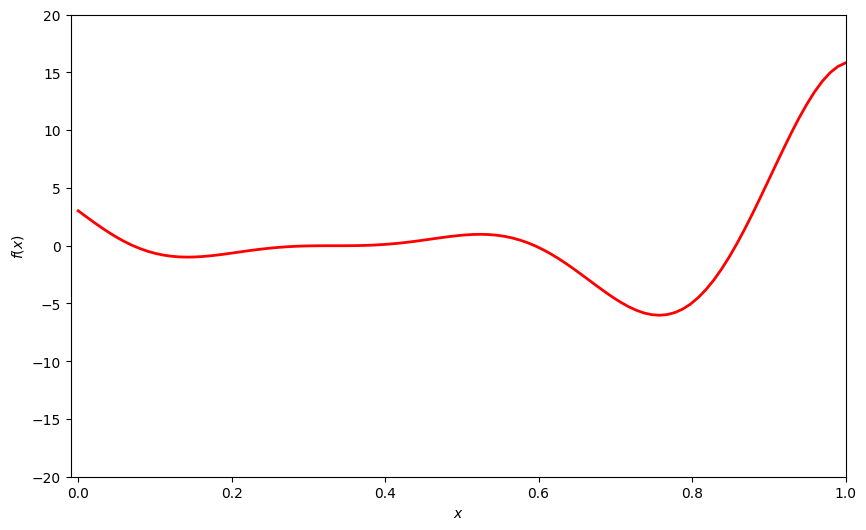

In [2]:
x = np.linspace(0, 1, 100)
f = (6*x-2)**2 * np.sin(12*x-4)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.plot(x, f, 'r-', linewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_xlim(-0.01, 1)
ax.set_ylim([-20, 20])

mlai.write_figure('forrester-function.svg', directory='./uq')

In [3]:
target_function, space = forrester_function()

In [4]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 301)[:, None]
y_plot = target_function(x_plot)

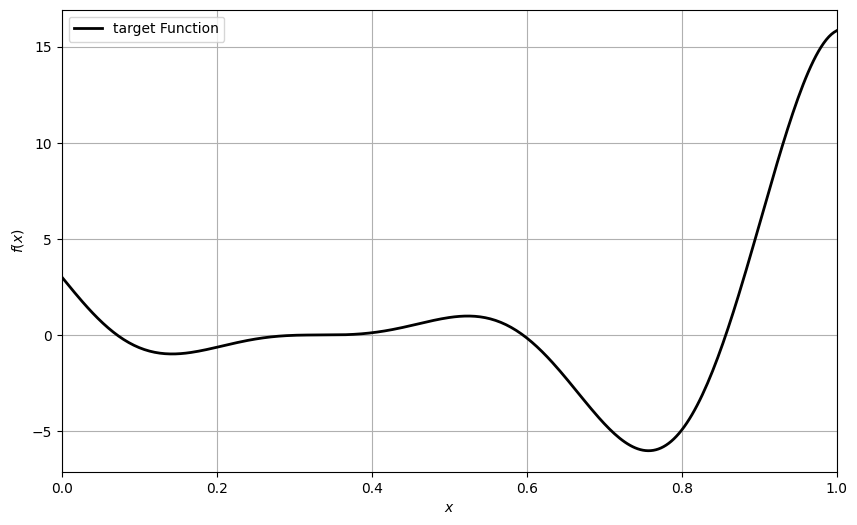

In [5]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.plot(x_plot, y_plot, 'k', label='target Function', linewidth=2)

ax.legend(loc=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.grid(True)
ax.set_xlim(0, 1)

mlai.write_figure(filename='forrester-function.svg', directory='./uq')

## Initial design
Usually, before we start the actual ExpDesign loop we need to gather a few observations such that we can fit the model. This is called the initial design and common strategies are either a predefined grid or sampling points uniformly at random. These strategies are known as model-free experimental design.

In [6]:
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

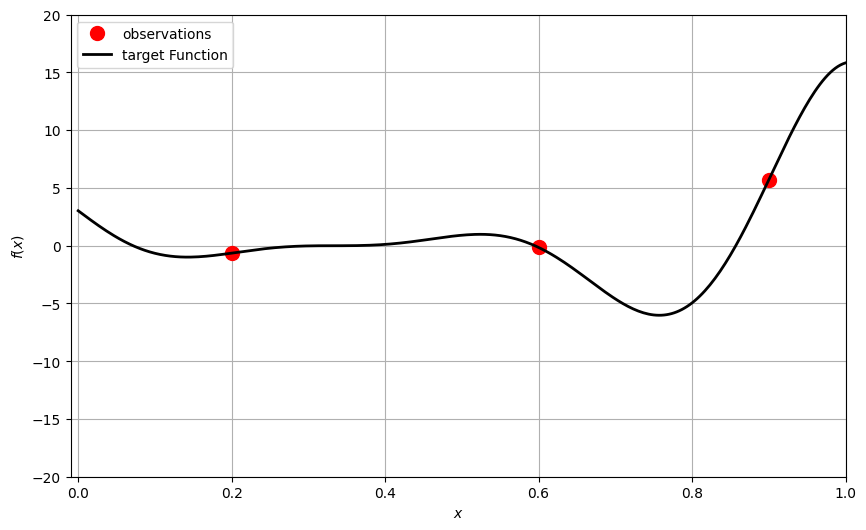

In [7]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.plot(X_init, Y_init, 'ro', markersize=10, label='observations')
ax.plot(x_plot, y_plot, 'k', label='target Function', linewidth=2)

ax.legend(loc=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.grid(True)
ax.set_xlim(-0.01, 1)
ax.set_ylim([-20, 20])

mlai.write_figure(filename='forrester-function-initial-design.svg', directory='./uq')

## 1. Model
Now we can start with the `ExpDesign` loop by first fitting a model on
the collected data. A popular model for `ExpDesign` is a Gaussian
process (GP) which defines a probability distribution across classes of
functions, typically smooth, such that each linear finite-dimensional
restriction is multivariate Gaussian (Rasmussen and Williams, 2006).
Gaussian processes are fully parametrized by a mean $\mu(\mathbf{ x})$
and a covariance function $k(\mathbf{ x},\mathbf{ x}^\prime)$. Without
loss of generality $\mu(\mathbf{ x})$ is assumed to be zero. The
covariance function $k(\mathbf{ x},\mathbf{ x}^\prime)$ characterizes
the smoothness and other properties of $f$. It is known that the kernel
of the process has to be continuous, symmetric and positive definite. A
widely used kernel is the exponentiated quadratic or RBF kernel: $$ 
k(\mathbf{ x},\mathbf{ x}^\prime) = \alpha \exp{ \left(-\frac{\|\mathbf{ x}-\mathbf{ x}^\prime\|^2}{2 \ell}\right)} 
$$ where $\alpha$ and $\ell$ are hyperparameters.

To denote that $f$ is a sample from a GP with mean $\mu$ and covariance
$k$ we write $$
f\sim \mathcal{GP}(\mu,k).
$$

For regression tasks, the most important feature of GPs is that process
priors are conjugate to the likelihood from finitely many observations
$\mathbf{Y}= (y_1,\dots,y_n)^\top$ and
$\mathbf{X}=\{\mathbf{ x}_1,\dots,\mathbf{ x}_n\}$,
$\mathbf{ x}_i\in \mathcal{X}$ of the form
$y_i = f(\mathbf{ x}_i) + \epsilon_i$ where
$\epsilon_i \sim \mathcal{N}\left(0,\sigma^2\right)$ and we typically
estimate $\sigma^2$ by maximum likelihood alongside $\alpha$ and $\ell$.

We obtain the Gaussian posterior $$
f(\mathbf{ x}^*)|\mathbf{X}, \mathbf{Y}, \theta \sim \mathcal{N}\left(\mu(\mathbf{ x}^*),\sigma^2(\mathbf{ x}^*)\right),
$$ where $\mu(\mathbf{ x}^*)$ and $\sigma^2(\mathbf{ x}^*)$ have a
closed form solution as we’ve seen in the earlier lectures (see also
Rasmussen and Williams (2006)).

Note that Gaussian processes are also characterized by hyperparameters,
for example in the exponentiated quadratic case we have
$\boldsymbol{ \theta}= \left\{ \alpha, \ell, \sigma^2 \right\}$ for the
scale of the covariance, the lengthscale and the noise variance. Here,
for simplicitly we will keep these hyperparameters fixed. However, we
will usually either optimize or sample these hyperparameters using the
marginal loglikelihood of the GP.

In this module we’ve focussed on Gaussian processes, but we could also
use any other model that returns a mean $\mu(\mathbf{ x})$ and variance
$\sigma^2(\mathbf{ x})$ on an arbitrary input points $\mathbf{ x}$ such
as Bayesian neural networks or random forests. In Emukit these different
models can also be used by defining a new `ModelWrapper`.

Here we’re going to wrap a GPy model.


See https://emukit.readthedocs.io/en/latest/notebooks/Emukit-tutorial-custom-model.html on how to include custom models

In [8]:
kern = GPy.kern.RBF(1, lengthscale=0.08, variance=20)
gpy_model = GPy.models.GPRegression(X_init, Y_init, kern, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

In [9]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [10]:
def helper_plot_emulator_errorbars():
    """Helper function for plotting the emulator fit."""
    ax.plot(emukit_model.X, emukit_model.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot, mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot, y_plot, 'k', label='target function', linewidth=2)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    ax.set_xlim(-0.01, 1)
    ax.set_ylim([-20, 20])

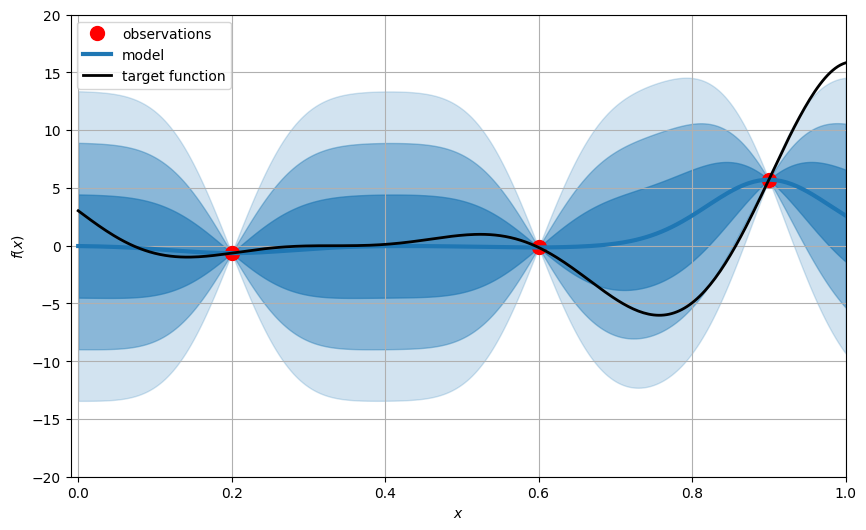

In [11]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars()
mlai.write_figure(filename='forrester-function-multi-errorbars-00.svg', directory='./uq')

## 2. Acquisition function
### Uncertainty Sampling

In uncertainty sampling (US) we hoose the next value $\mathbf{ x}_{n+1}$
at the location where the model on $f(\mathbf{ x})$ has the highest
marginal predictive variance $$
a_{US}(\mathbf{ x}) = \sigma^2(\mathbf{ x}).
$$ This makes sure, that we learn the function $f(\cdot)$ everywhere on
$\mathbb{X}$ to a similar level of absolute error.

### Integrated Variance Reduction

In the integrated variance reduction (IVR) you choose the next value
$\mathbf{ x}_{n+1}$ such that the total variance of the model is reduced
maximally (Sacks et al., 1989), $$
\begin{align*}
a_{\text{IVR}} & = \int_{\mathbb{X}}[\sigma^2(\mathbf{ x}') - \sigma^2(\mathbf{ x}'; \mathbf{ x})]\text{d}\mathbf{ x}' \\
& \approx 
\frac{1}{\# \text{samples}}\sum_i^{\# \text{samples}}[\sigma^2(\mathbf{ x}_i) - \sigma^2(\mathbf{ x}_i; \mathbf{ x})].
\end{align*}
$$ Here $\sigma^2(\mathbf{ x}'; \mathbf{ x})$ is the predictive variance
at $\mathbf{ x}'$ had $\mathbf{ x}$ been observed. Thus IVR computes the
overall reduction in variance (for all points in $\mathbb{X}$) had $f$
been observed at $\mathbf{ x}$.

The finite sum approximation on the right hand side of the equation is
usually used because the integral over $\mathbf{ x}'$ is not analytic.
In that case $\mathbf{ x}_i$ are sampled randomly. For a GP model the
right hand side simplifies to

$$
a_{LCB} \approx \frac{1}{\# \text{samples}}\sum_i^{\# \text{samples}}\frac{k^2(\mathbf{ x}_i, \mathbf{ x})}{\sigma^2(\mathbf{ x})}.
$$

IVR is arguably the more principled approach, but often US is preferred
over IVR simply because it lends itself to gradient based optimization
more easily, is cheaper to compute, and is exact.

For both of them (stochastic) gradient base optimizers are used to
retrieve
$\mathbf{ x}_{n+1} \in \operatorname*{arg\:max}_{\mathbf{ x}\in \mathbb{X}} a(\mathbf{ x})$.

In [12]:
us_acquisition = ModelVariance(emukit_model)
ivr_acquisition = IntegratedVarianceReduction(emukit_model, space)

us_plot = us_acquisition.evaluate(x_plot)
ivr_plot = ivr_acquisition.evaluate(x_plot)

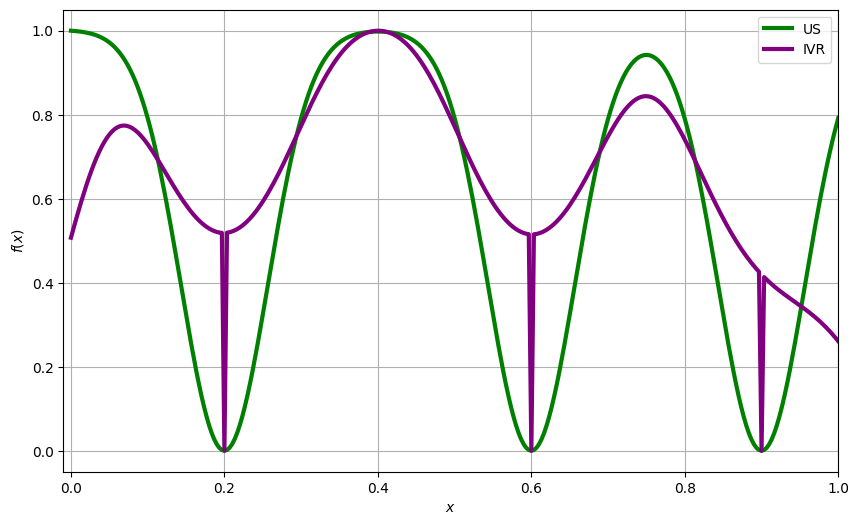

In [13]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.plot(x_plot, us_plot / np.max(us_plot), 'green', label='US', linewidth=3)
ax.plot(x_plot, ivr_plot / np.max(ivr_plot) , 'purple', label='IVR', linewidth=3)

ax.legend(loc=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.grid(True)
ax.set_xlim(-0.01, 1)

mlai.write_figure('experimental-design-acquisition-forrester-00.svg', directory='./uq')

## 3. Evaluate objective function

In [14]:
# def helper_plot_next_point_acquisition():
#     """Helper code for plot the location of the next point acquisition."""
#     ax.plot(x_plot, us_plot / np.max(us_plot), 'green', label='US', linewidth=3)
#     ax.axvline(x_new, color='red', label='x_next', linestyle='--', linewidth=3)
#     ax.legend(loc=1)
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$f(x)$')
#     ax.grid(True)
#     ax.set_xlim(-0.01, 1)



In [15]:
# # To find the next point to evaluate we optimize the acquisition 
# # function using a standard gradient descent optimizer.

# optimizer = GradientAcquisitionOptimizer(space)
# x_new, _ = optimizer.optimize(us_acquisition)

In [16]:
# fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
# helper_plot_next_point_acquisition()
# mlai.write_figure('experimental-design-acquisition-forrester-01.svg', directory='./uq')

In [17]:
# y_new = target_function(x_new)

In [18]:
# X = np.append(X_init, x_new, axis=0)
# Y = np.append(Y_init, y_new, axis=0)

#### Update the model

In [19]:
# emukit_model.set_data(X, Y)
# mu_plot, var_plot = emukit_model.predict(x_plot)

In [20]:
# fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
# helper_plot_emulator_errorbars()

# mlai.write_figure(filename='forrester-function-multi-errorbars-01.svg', directory='./uq')

#### Repeat

In [21]:
# us_acquisition = ModelVariance(emukit_model)
# us_plot = us_acquisition.evaluate(x_plot)
# x_new, _ = optimizer.optimize(us_acquisition)

In [22]:
# fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
# helper_plot_next_point_acquisition()

# mlai.write_figure('experimental-design-acquisition-forrester-02.svg', directory='./uq')

In [23]:
# y_new = target_function(x_new)
# X = np.append(X, x_new, axis=0)
# Y = np.append(Y, y_new, axis=0)
# emukit_model.set_data(X, Y)
# mu_plot, var_plot = emukit_model.predict(x_plot)

In [24]:
# fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
# helper_plot_emulator_errorbars()

# mlai.write_figure(filename='forrester-function-multi-errorbars-02.svg', directory='./uq')

## 3. Evaluate and update multiple times - LOOP

#### ExperimentalDesignLoop
:param space: Definition of domain bounds to collect points within

:param model: The model that approximates the underlying function

:param acquisition: experimental design acquisition function object. Default: ModelVariance acquisition

:param update_interval: How many iterations pass before next model optimization

:param batch_size: Number of points to collect in a batch. Defaults to one.

:param acquisition_optimizer: Optimizer selecting next evaluation points
                              by maximizing acquisition.
                              Gradient based optimizer is used if None.
                              Defaults to None.


The loop can be used in two modes:

1. Emukit calculates the next point(s) to try and evaluates your function at these points until some stopping
   criterion is met.
2. Emukit only calculates the next points(s) to try and you evaluate your function or perform the experiment.

This object exposes the following events. See ``emukit.core.event_handler`` for details of how to subscribe:
     - ``loop_start_event`` called at the start of the `run_loop` method
     - ``iteration_end_event`` called at the end of each iteration


In [25]:
ed = ExperimentalDesignLoop(
    space=space, 
    model=emukit_model,
    acquisition=None,  # Default: ModelVariance acquisition
    update_interval=1,
    batch_size=1,
    acquisition_optimizer=None,
)


ed.run_loop(target_function, 10)

In [26]:
mu_plot, var_plot = ed.model.predict(x_plot)

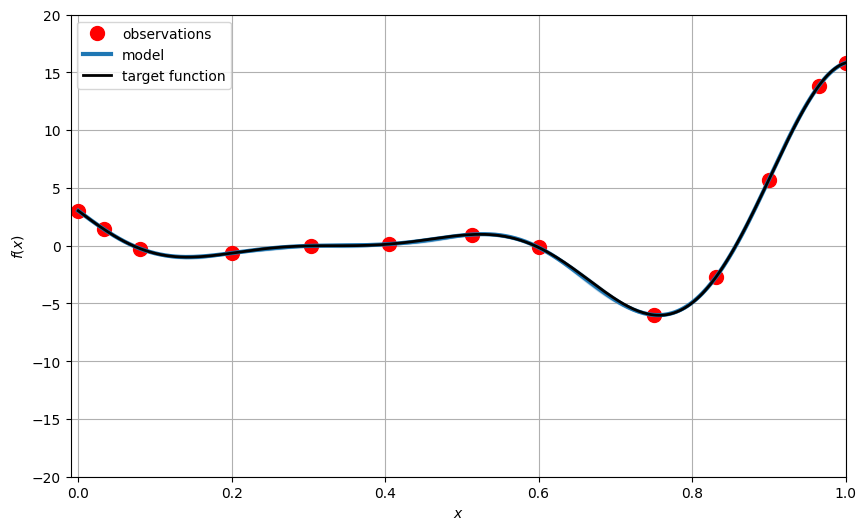

In [27]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars()

mlai.write_figure(filename='forrester-function-full-fit.svg', directory='./uq')